In [1]:
# !pip install uv > /dev/null 2>&1

# # Then, install all other packages in one go
# !uv pip install "jax[cuda12_pip]"==0.4.31 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html git+https://github.com/handley-lab/blackjax@nested_sampling git+https://git.ligo.org/lscsoft/ligo-segments.git git+https://github.com/kazewong/jim anesthetic > /dev/null 2>&1


In [2]:
import blackjax
import jax
import jax.numpy as jnp
import numpy as np
import tqdm
from anesthetic import NestedSamples, read_chains
from jimgw.prior import (
    CombinePrior,
    CosinePrior,
    PowerLawPrior,
    SinePrior,
    UniformPrior,
)
import timeit

from jimgw.single_event.detector import H1, L1
from jimgw.single_event.likelihood import TransientLikelihoodFD, HeterodynedTransientLikelihoodFD
from jimgw.single_event.transforms import (
    MassRatioToSymmetricMassRatioTransform,
)
from jimgw.single_event.waveform import RippleIMRPhenomD

from jimgw.single_event.transforms import (
    SkyFrameToDetectorFrameSkyPositionTransform,
    SphereSpinToCartesianSpinTransform,
    MassRatioToSymmetricMassRatioTransform,
    DistanceToSNRWeightedDistanceTransform,
    GeocentricArrivalTimeToDetectorArrivalTimeTransform,
    GeocentricArrivalPhaseToDetectorArrivalPhaseTransform,
)
from jimgw.transforms import BoundToUnbound


jax.config.update("jax_enable_x64", True)

# | Fetch ligo data
root = "GW150914_IMRPhenomD"
filename = f"{root}.csv"
gps = 1126259462.4
fmin = 20.0
fmax = 1024.0
H1.load_data(gps, 2, 2, fmin, fmax, psd_pad=16, tukey_alpha=0.2)
L1.load_data(gps, 2, 2, fmin, fmax, psd_pad=16, tukey_alpha=0.2)

# | Define the waveform
transforms = [
    MassRatioToSymmetricMassRatioTransform,
]
waveform = RippleIMRPhenomD(f_ref=20)

# | Define the prior
prior = CombinePrior(
    [
        UniformPrior(10.0, 80.0, parameter_names=["M_c"]),
        UniformPrior(0.125, 1.0, parameter_names=["q"]),
        UniformPrior(-1.0, 1.0, parameter_names=["s1_z"]),
        UniformPrior(-1.0, 1.0, parameter_names=["s2_z"]),
        SinePrior(parameter_names=["iota"]),
        PowerLawPrior(1.0, 2000.0, 2.0, parameter_names=["d_L"]),
        UniformPrior(-0.05, 0.05, parameter_names=["t_c"]),
        # UniformPrior(-0.1, 0.1, parameter_names=["t_c"]),
        UniformPrior(0.0, 2 * jnp.pi, parameter_names=["phase_c"]), # wraparound
        UniformPrior(0.0, jnp.pi, parameter_names=["psi"]), # wraparound
        UniformPrior(0.0, 2 * jnp.pi, parameter_names=["ra"]),
        CosinePrior(parameter_names=["dec"]),
    ]
)

keys = prior.parameter_names


def create_mask_from_indices(num_keys, target_indices):
    return jnp.zeros(num_keys, dtype=bool).at[target_indices].set(True)

phase_c_idx = keys.index("phase_c")  # 7
psi_idx = keys.index("psi")  # 8
ra_idx = keys.index("ra")

# wrap_mask = create_mask_from_indices(len(keys), jnp.array([phase_c_idx, psi_idx,ra_idx]))
wrap_mask = create_mask_from_indices(len(keys), jnp.array([phase_c_idx, psi_idx]))
# wrap_mask = jnp.zeros(len(keys), dtype=bool)

wrap_periods = jnp.ones(len(keys))
wrap_periods = wrap_periods.at[psi_idx].set(jnp.pi)
wrap_periods = wrap_periods.at[phase_c_idx].set(2 * jnp.pi)
wrap_periods = wrap_periods.at[ra_idx].set(2 * jnp.pi)


alpha_ordered_param_names = sorted(keys)

# 2. Create permutation indices to map from original order to alphabetical order
perm_indices_from_orig_to_alpha = jnp.array([keys.index(name) for name in alpha_ordered_param_names])

# 3. Pre-permute wrap_mask and wrap_periods to be in alphabetical parameter order
#    These are JAX arrays and will be passed as compile-time constants via partial.
# wrap_mask = wrap_mask[perm_indices_from_orig_to_alpha]
# wrap_periods = wrap_periods[perm_indices_from_orig_to_alpha]


labels = {
    "M_c": r"$M_c$",
    "q": r"$q$",
    "s1_z": r"$s_{1z}$",
    "s2_z": r"$s_{2z}$",
    "iota": r"$\iota$",
    "d_L": r"$d_L$",
    "t_c": r"$t_c$",
    "phase_c": r"$\phi_c$",
    "psi": r"$\psi$",
    "ra": r"$\alpha$",
    "dec": r"$\delta$",
}

ifos = [H1, L1]

ref_param = {
    "M_c": 3.10497857e01,
    # "eta": 2.46759666e-01,
    "eta": 0.15874815,
    "s1_z": 3.04854781e-01,
    "s2_z": -4.92774588e-01,
    "d_L": 5.47223231e02,
    "t_c": 1.29378808e-02,
    "phase_c": 3.30994042e00,
    "iota": 3.88802965e-01,
    "psi": 3.41074151e-02,
    "ra": 2.55345319e00,
    "dec": -9.52109059e-01,
}

sample_transforms = [
    DistanceToSNRWeightedDistanceTransform(gps_time=gps, ifos=ifos, dL_min=0.0, dL_max=2000.),
    GeocentricArrivalPhaseToDetectorArrivalPhaseTransform(gps_time=gps, ifo=ifos[0]),
    GeocentricArrivalTimeToDetectorArrivalTimeTransform(tc_min=-0.05, tc_max=0.05, gps_time=gps, ifo=ifos[0]),
    SkyFrameToDetectorFrameSkyPositionTransform(gps_time=gps, ifos=ifos),
]


likelihood = HeterodynedTransientLikelihoodFD(
    ifos,
    waveform=waveform,
    # n_bins=301,
    trigger_time=gps,
    duration=4,
    post_trigger_duration=2,
    prior=prior,
    # sample_transforms=sample_transforms,
    likelihood_transforms=transforms,
    ref_params=ref_param,
    popsize=10,
    n_steps=5,
)


Fetching data from H1...
Fetching PSD data...
Finished loading data.
Fetching data from L1...
Fetching PSD data...
Finished loading data.
Initializing heterodyned likelihood..
Reference parameters provided, which are {'M_c': 31.0497857, 'eta': 0.15874815, 's1_z': 0.304854781, 's2_z': -0.492774588, 'd_L': 547.223231, 't_c': 0.0129378808, 'phase_c': 3.30994042, 'iota': 0.388802965, 'psi': 0.0341074151, 'ra': 2.55345319, 'dec': -0.952109059}
Constructing reference waveforms..


In [3]:
def loglikelihood(x):
    like = likelihood.evaluate(
        jax.tree_util.tree_map(
            lambda y: y.squeeze(), transforms[0].forward(x)
        ),
        None,
    )
    # like = likelihood.evaluate(x, None)
    like = jnp.where((x["iota"] >= 0.0) & (x["iota"] <= jnp.pi), like, -jnp.inf)
    like = jnp.where((x["dec"] >= -jnp.pi/2) & (x["dec"] <= jnp.pi/2), like, -jnp.inf)
    # for i in sample_transforms:
    #   x = i.forward(x)
    return like

In [ ]:
from jax.flatten_util import ravel_pytree
from blackjax.ns.utils import get_first_row
from blackjax.smc.tuning.from_particles import (
    particles_as_rows,
    particles_covariance_matrix,
    particles_stds,
)


# def calc_covmat_jax(x, wraparound):
#     # x: (nDims, n) array
#     # wraparound: (nDims,) boolean array

#     nDims, n = x.shape

#     circle_mu_angular_part = jnp.atan2(
#         jnp.sum(jnp.sin(x * (2.0 * jnp.pi)), axis=1),
#         jnp.sum(jnp.cos(x * (2.0 * jnp.pi)), axis=1),
#     ) / (2.0 * jnp.pi)

#     initial_mean_estimate = jnp.where(wraparound, circle_mu_angular_part, 0.0)


#     circle_mu = jnp.where(wraparound, circle_mu_angular_part, 0.0)
#     dx = x - circle_mu[:, jnp.newaxis]

#     wraparound_broadcast = wraparound[:, jnp.newaxis]
#     dx = jnp.where(wraparound_broadcast, dx - jnp.round(dx), dx)

#     mu = jnp.mod(jnp.sum(dx, axis=1) / n + circle_mu, 1.0)
#     dx = x - mu[:, jnp.newaxis]
#     dx = jnp.where(wraparound_broadcast, dx - jnp.round(dx), dx)
#     covmat = (dx @ dx.T) / (n)

#     return covmat


def calc_covmat_jax(x, wraparound, wrap_periods):
    nDims, n_particles = x.shape

    x_normalized_for_trig = x / wrap_periods[:, jnp.newaxis]

    # mean_sin_term = jnp.sum(jnp.sin(x * 2.0 * jnp.pi), axis=1)
    # mean_cos_term = jnp.sum(jnp.cos(x * 2.0 * jnp.pi), axis=1)
    mean_sin_term = jnp.sum(jnp.sin(x_normalized_for_trig * 2.0 * jnp.pi), axis=1)
    mean_cos_term = jnp.sum(jnp.cos(x_normalized_for_trig * 2.0 * jnp.pi), axis=1)

    circular_mean_angular = jnp.atan2(mean_sin_term, mean_cos_term)
    circular_mean_component = jnp.mod(circular_mean_angular / (2.0 * jnp.pi), 1.0)

    linear_mean_component = jnp.sum(x, axis=1) / n_particles

    # Inside calc_covmat_jax:
    circular_mean_component_original_scale = (
        circular_mean_component * wrap_periods
    )  # Element-wise multiplication

    mu = jnp.where(
        wraparound,
        circular_mean_component_original_scale,  # Use the scaled version
        linear_mean_component,
    )

    # mu = jnp.where(wraparound, circular_mean_component, linear_mean_component)

    dx = x - mu[:, jnp.newaxis]

    # dx_adjusted_for_wrap = dx - jnp.round(dx)
    # dx = jnp.where(wraparound[:, jnp.newaxis], dx_adjusted_for_wrap, dx)
    dx_fractional = dx / wrap_periods[:, jnp.newaxis]

    #    b. Find shortest arc in the fractional [-0.5, 0.5) domain
    dx_fractional_shortest_arc = dx_fractional - jnp.round(dx_fractional)

    #    c. Scale the shortest fractional arc back to original units
    dx_shortest_arc_original_scale = (
        dx_fractional_shortest_arc * wrap_periods[:, jnp.newaxis]
    )

    # 3. Apply the shortest arc adjustment only for wrapped parameters
    dx = jnp.where(wraparound[:, jnp.newaxis], dx_shortest_arc_original_scale, dx)

    covmat = (dx @ dx.T) / (n_particles - 1.0)

    return covmat


def compute_covariance_from_particles(state, info, inner_kernel_params):
    particles = particles_as_rows(state.particles).T
    # cov_matrix = calc_covmat_jax(particles, wrap_mask, wrap_periods)
    cov_matrix = calc_covmat_jax(particles, wrap_mask)
    single_particle = get_first_row(state.particles)
    _, unravel_fn = ravel_pytree(single_particle)
    cov_pytree = jax.vmap(unravel_fn)(cov_matrix)
    return {"cov": cov_pytree}


# def compute_covariance_from_particles(
#     state,
#     info,
#     inner_kernel_params):
#     # cov_matrix = particles_covariance_matrix(state.particles)
#     cov_matrix = jnp.diag(particles_stds(state.particles))
#     single_particle = get_first_row(state.particles)
#     _, unravel_fn = ravel_pytree(single_particle)
#     cov_pytree = jax.vmap(unravel_fn)(cov_matrix)
#     return {"cov": cov_pytree}


def default_stepper_fn(x, d, t):
    y = jax.tree.map(lambda x, d: x + t * d, x, d)
    y["phase_c"] = jnp.mod(y["phase_c"], 2 * jnp.pi)
    # y["psi"] = jnp.remainder(y["psi"], jnp.pi)
    y["psi"] = jnp.mod(y["psi"], jnp.pi)
    y["ra"] = jnp.mod(y["ra"], 2 * jnp.pi)
    return y


In [ ]:
n_dims = len(prior.parameter_names)
n_live = 2000
n_delete = int( 0.5 * n_live)
num_mcmc_steps = n_dims * 10


# | Initialize the Nested Sampling algorithm
nested_sampler = blackjax.nss(
    logprior_fn=prior.log_prob,
    loglikelihood_fn=loglikelihood,
    num_delete=n_delete,
    num_inner_steps=num_mcmc_steps,
    stepper_fn = default_stepper_fn,
    # adapt_direction_params_fn = compute_covariance_from_particles
)


@jax.jit
def one_step(carry, xs):
    state, k = carry
    k, subk = jax.random.split(k, 2)
    state, dead_point = nested_sampler.step(subk, state)
    return (state, k), dead_point




# | Sample live points from the prior
rng_key = jax.random.PRNGKey(0)
rng_key, init_key = jax.random.split(rng_key, 2)
initial_particles = prior.sample(init_key, n_live)
state = nested_sampler.init(initial_particles)



In [6]:
dead = []
with tqdm.tqdm(desc="Dead points", unit=" dead points") as pbar:
          while not state.logZ_live - state.logZ < -3:
              (state, rng_key), dead_info = one_step((state, rng_key), None)
              dead.append(dead_info)
              pbar.update(n_delete)  # Update progress bar

Dead points: 25000 dead points [02:24, 173.33 dead points/s]


In [7]:
from blackjax.ns.utils import finalise

final_state = finalise(state,dead)

In [8]:
from anesthetic import NestedSamples
samples = NestedSamples(
    final_state.particles,
    logL=final_state.loglikelihood,
    logL_birth=final_state.loglikelihood_birth,
    # columns=columns,
    labels=labels,
    logzero=jnp.nan,
    dtype=jnp.float64,
)

/usr/local/lib/python3.11/dist-packages/anesthetic/labelled_pandas.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_map.loc[labels_map == ''] = replacement.astype(


,psi,phase_c,iota,ra,dec
psi,DiagonalAx...,OffDiagona...,OffDiagona...,OffDiagona...,OffDiagona...
phase_c,OffDiagona...,DiagonalAx...,OffDiagona...,OffDiagona...,OffDiagona...
iota,OffDiagona...,OffDiagona...,DiagonalAx...,OffDiagona...,OffDiagona...
ra,OffDiagona...,OffDiagona...,OffDiagona...,DiagonalAx...,OffDiagona...
dec,OffDiagona...,OffDiagona...,OffDiagona...,OffDiagona...,DiagonalAx...


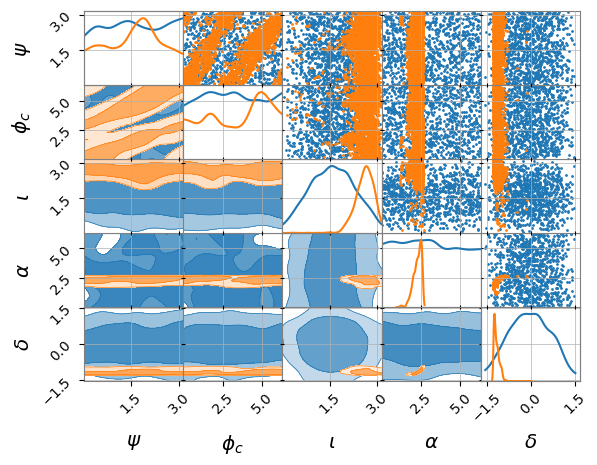

In [9]:
import matplotlib.pyplot as plt
a = samples.set_beta(0.0).plot_2d(["psi","phase_c", "iota", "ra", "dec"])
# a = samples.set_beta(0.0).plot_2d(["M_c","q", "ra", "dec"])
samples.plot_2d(a)
# plt.tight_layout()
# plt.savefig("corner.pdf")


,M_c,q,ra,dec
M_c,DiagonalAx...,None,None,None
q,OffDiagona...,DiagonalAx...,None,None
ra,OffDiagona...,OffDiagona...,DiagonalAx...,None
dec,OffDiagona...,OffDiagona...,OffDiagona...,DiagonalAx...


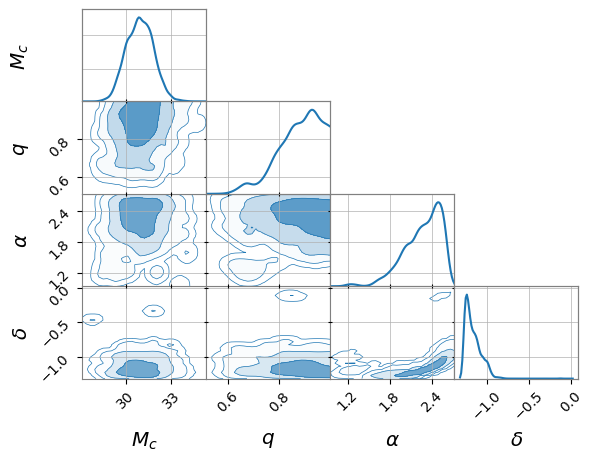

In [10]:
from anesthetic import make_2d_axes

f,a = make_2d_axes(["M_c","q", "ra", "dec"], upper=False, lower="scatter_2d")
# f,a = make_2d_axes(["psi","phase_c", "iota", "ra", "dec"], upper=False, lower="scatter_2d")
samples.plot_2d(a, kinds='kde', levels=[0.99994, 0.99730, 0.95450, 0.68269], lower_kwargs={"bw_method":"silverman"})